# `<brilliant seminar title>`

In this seminar, we're going to play with [Tensorflow](https://www.tensorflow.org/) and see how it helps us build deep learning models.

If you're running this notebook outside course environment, you'll need to install tensorflow:
* `pip install tensorflow` should install cpu-only TF on Linux & Mac OS
* If you want GPU support from offset, see [TF install page](https://www.tensorflow.org/install/)

# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.
* Use numpy or python
* An array of numbers 0 to N - numpy.arange(N)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [ ]:
def sum_squares(N):
    return sum([x**2 for x in range(N)])

%%time
sum_squares(10**8)

# Tensoflow teaser

Doing the very same thing

In [2]:
import tensorflow as tf
tf.__version__

'1.1.0'

In [7]:
#I gonna be your function parameter
with tf.Graph().as_default():
    N = tf.placeholder('int64', name="input_to_your_function")
    result = tf.reduce_sum((tf.range(N)**2))
    #show graph to tensorboard
    writer = tf.summary.FileWriter("/tmp/tboard", graph=tf.get_default_graph())
    writer.close()
    
    with tf.Session() as session:
        %%time
        print(session.run(result, feed_dict={N:10**1}))
        

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs
285


# How does it work?
1. define placeholders where you'll send inputs;
2. make symbolic graph: a recipe for mathematical transformation of those placeholders;
3. compute outputs of your graph with particular values for each placeholder
  * output.eval({placeholder:value}) 
  * s.run(output, {placeholder:value})

* So far there are two main entities: "placeholder" and "transformation"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats of booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * tf.reduce_sum(tf.arange(N)\**2) are 3 sequential transformations of placeholder N
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * np.mean -> tf.reduce_mean
   * np.arange -> tf.range
   * np.cumsum -> tf.cumsum
   * If if you can't find the op you need, see the docs [docs](https://www.tensorflow.org/api_docs/python).
 
 
Still confused? We gonna fix that.

In [ ]:
#Default placeholder that can be arbitrary float32 scalar, vertor, matrix, etc.
arbitrary_input = tf.placeholder('float32')

#Input vector of arbitrary length
input_vector = tf.placeholder('float32',shape=(None,))

#Input vector that _must_ have 10 elements and integer type
fixed_vector = tf.placeholder('int32',shape=(10,))

#Matrix of arbitrary n_rows and 15 columns (e.g. a minibatch your data table)
input_matrix = tf.placeholder('float32',shape=(None,15))

#You can generally use None whenever you don't need a specific shape
input1 = tf.placeholder('float64',shape=(None,100,None))
input2 = tf.placeholder('int32',shape=(None,None,3,224,224))


In [ ]:
#elementwise multiplication
double_the_vector = input_vector*2

#elementwise cosine
elementwise_cosine = tf.cos(input_vector)

#difference between squared vector and vector itself
vector_squares = input_vector**2 - input_vector


In [ ]:
#Practice time:
#create two vectors of size float32
my_vector = tf.placeholder('float32',shape=(None,), name='vec1')
my_vector2 = tf.placeholder('float32',shape=(None,), name='vec2')

In [ ]:
#Write a transformation(recipe):
#(vec1)*(vec2) / (sin(vec1) +1)
my_transformation = my_vector*my_vector2/(tf.sin(my_vector) + 1)

In [ ]:
print(my_transformation)
#it's okay, it's a symbolic graph

In [ ]:
dummy = np.arange(5).astype('float32')

my_transformation.eval({my_vector:dummy,my_vector2:dummy[::-1]})

### Visualizing graphs

It's often useful to visualize the computation graph when debugging or optimizing. 
Interactive visualization is where tensorflow really shines as compared to other frameworks. 

There's a special instrument for that, called Tensorboard. You can launch it from console:

```tensorboard --logdir=/tmp/tboard --port=7007```

If you're pathologically afraid of consoles, try this:

```os.system("tensorboard --logdir=/tmp/tboard --port=7007 &"```

_(but don't tell anyone we taught you that)_

In [6]:
#launch tensorflow the ugly way, uncomment if you need that
#!killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &")

0

One basic functionality of tensorboard is drawing graphs. One you've run the cell above, go to `localhost:7007` in your browser and switch to _graphs_ tab in the topbar. 

Here's what you should see:

<img src="https://s12.postimg.org/a374bmffx/tensorboard.png" width=480>

Tensorboard also allows you to draw graphs (e.g. learning curves), record images & audio ~~and play flash games~~. This is useful when monitoring learning progress and catching some training issues.

One researcher said:
```
If you spent last four hours of your worktime watching as your algorithm prints numbers and draws figures, you're probably doing deep learning wrong.
```

You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz)

# Do It Yourself

__[2 points max]__

In [8]:
# Quest #1 - implement a function that computes a mean squared error of two input vectors
# Your function has to take 2 vectors and return a single number
def compute_mse(e1, e2):
    with tf.Graph().as_default():
        v1 = tf.placeholder('float32', shape=(None,))
        v2 = tf.placeholder('float32', shape=(None,))
        mse = tf.reduce_mean(tf.squared_difference(v1, v2))
        with tf.Session() as session:
            return session.run(mse, feed_dict={v1:e1, v2:e2})

In [12]:
# Tests
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print('Wrong result:')
                print('mse(%s,%s)'%(el,el_2))
                print("should be: %f, but your function returned %f"%(true_mse,my_mse))
                raise(ValueError,"Что-то не так")

print("All tests passed")


All tests passed


# variables

The inputs and transformations have no value outside function call. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [15]:
with tf.Graph().as_default():
    #creating shared variable
    shared_vector_1 = tf.Variable(initial_value=np.ones(5))
    
    with tf.Session() as s:
        #initialize variable(s) with initial values
        s.run(tf.global_variables_initializer())

        #evaluating shared variable (outside symbolicd graph)
        print("initial value",s.run(shared_vector_1))

        # within symbolic graph you use them just as any other inout or transformation, 
        # not "get value" needed

        #setting new value
        s.run(shared_vector_1.assign( np.arange(5) ))

        # getting that new value
        print("new value", s.run(shared_vector_1))

        # Note that the vector changed shape
        # This is entirely allowed... unless your graph is hard-wired to work with some fixed shape

initial value [ 1.  1.  1.  1.  1.]
new value [ 0.  1.  2.  3.  4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* Gradients are computed as a product of elementary derivatives via chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

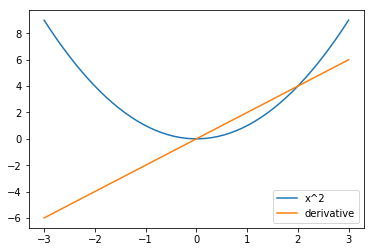

In [16]:
with tf.Graph().as_default():
    my_scalar = tf.placeholder('float32')
    scalar_squared = my_scalar**2

    #a derivative of scalar_squared by my_scalar
    derivative = tf.gradients(scalar_squared, my_scalar)[0]
    
    with tf.Session() as s:

        x = np.linspace(-3,3)
        x_squared, x_squared_der = s.run([scalar_squared, derivative],
                                         {my_scalar:x})

        plt.plot(x, x_squared, label="x^2")
        plt.plot(x, x_squared_der, label="derivative")
        plt.legend()

# Why that rocks

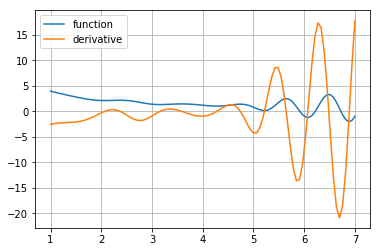

In [7]:
with tf.Graph().as_default():
    my_scalar = tf.placeholder('float32')
    my_vector = tf.placeholder('float32', [None])

    #Compute the gradient of the next weird function over my_scalar and my_vector
    #warning! Trying to understand the meaning of that function may result in permanent brain damage

    weird_psychotic_function = tf.reduce_mean((my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) +1./ tf.atan(my_scalar))/(my_scalar**2 +1) + 0.01*tf.sin(2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2)*tf.exp((my_scalar-4)**2)/(1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2))/(1+tf.exp(-(my_scalar-4)**2)))**2

    with tf.Session() as s:
        der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)[0]

        #Plotting your derivative
        scalar_space = np.linspace(1,7,100)

        y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1,2,3]})
             for x in scalar_space]

        plt.plot(scalar_space,y,label='function')

        y_der_by_scalar = [s.run(der_by_scalar, {my_scalar:x, my_vector:[1,2,3]})
             for x in scalar_space]

        plt.plot(scalar_space, y_der_by_scalar, label='derivative')
        plt.grid();plt.legend()

# Almost done - optimizers

While you can perform gradient descent by hand with automatic grads from above, tensorflow also has some optimization methods implemented for you. Recall mommentum & rmsprop?

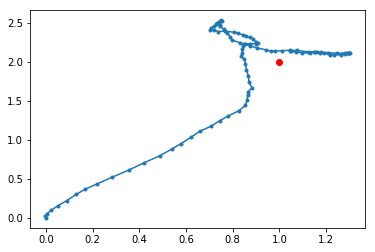

In [10]:
with tf.Graph().as_default():
    y_guess = tf.Variable(np.zeros(2, dtype='float32'))
    y_true = tf.range(1, 3, dtype='float32')

    loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 

    optimizer = tf.train.MomentumOptimizer(0.01,0.9).minimize(loss, var_list=y_guess)

    #same, but more detailed:
    #updates = [[tf.gradients(loss,y_guess)[0], y_guess]]
    #optimizer = tf.train.MomentumOptimizer(0.01,0.9).apply_gradients(updates)
    
    with tf.Session() as s:
    
        s.run(tf.global_variables_initializer())
        guesses = [s.run(y_guess)]

        for _ in range(100):
            s.run(optimizer)
            guesses.append(s.run(y_guess))

            clear_output(True)
            plt.plot(*zip(*guesses), marker='.')
            plt.scatter(*s.run(y_true), c='red')
            plt.show()

# Logistic regression example
__[ 4 points max]__

Implement the regular logistic regression training algorithm

Tips:
* Weights fit in as a shared variable
* X and y are potential inputs
* Compile 2 functions:
 * train_function(X,y) - returns error and computes weights' new values __(through updates)__
 * predict_fun(X) - just computes probabilities ("y") given data
 
 
We shall train on a two-class MNIST dataset
* please note that target y are {0,1} and not {-1,1} as in some formulae

In [25]:
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

mnist = load_digits(2)

X, y = mnist.data, mnist.target

X_train,X_test,y_train,y_test = train_test_split(X,y)


print("y_train [shape - %s]"%(str(y_train.shape)))
print("X_train [shape - %s]"%(str(X_train.shape)))
print("y_test [shape - %s]"%(str(y_test.shape)))
print("X_test [shape - %s]"%(str(X_test.shape)))

print(X[:1])
print(y[:10])

y_train [shape - (270,)]
X_train [shape - (270, 64)]
y_test [shape - (90,)]
X_test [shape - (90, 64)]
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]]
[0 1 0 1 0 1 0 0 1 1]


loss at iter 0:0.6700
train auc: 0.606343283582
test auc: 0.53125
loss at iter 1:0.6965
train auc: 0.548507462687
test auc: 0.791666666667
loss at iter 2:0.4585
train auc: 0.865671641791
test auc: 0.979166666667
loss at iter 3:0.3504
train auc: 0.955223880597
test auc: 0.989583333333
loss at iter 4:0.3348
train auc: 0.992537313433
test auc: 1.0
resulting weights:


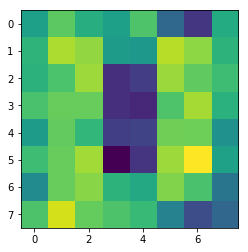

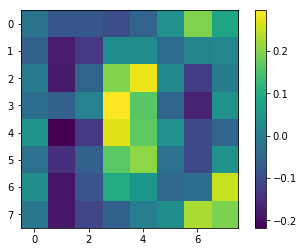

In [30]:
with tf.Graph().as_default():

    # inputs and shareds
    weights = tf.Variable(tf.truncated_normal((64, 2), 0, 0.05, tf.float32))
    input_X = tf.placeholder('float32', (None, 64))
    input_y = tf.placeholder('int32', (None,))

    predicted_score = tf.sigmoid(tf.matmul(input_X, weights))
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=predicted_score,
                                                                         labels=input_y))

    train_step = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss)

    with tf.Session() as s:
        
        tf.global_variables_initializer().run()

        for i in range(5):
            _, loss_i, scores= s.run([train_step, loss, predicted_score],
                                      feed_dict={input_X:X_train, input_y:y_train})

            print ("loss at iter %i:%.4f"%(i, loss_i))
            labels = np.argmax(scores, axis=1)             
            print("train auc:", roc_auc_score(y_train, labels))
            
            scores = s.run(predicted_score,
                           feed_dict={input_X:X_test, input_y:y_test})
            labels = np.argmax(scores, axis=1) 
            print("test auc:", roc_auc_score(y_test, labels))
            
            w = s.run(weights)


    print("resulting weights:")
    plt.imshow(w[:,0].reshape(8,-1))
    plt.show()
    plt.imshow(w[:,1].reshape(8,-1))
    plt.colorbar()

# my1stNN
__[basic part 4 points max]__
Your ultimate task for this week is to build your first neural network [almost] from scratch and pure tensorflow.

This time you will same digit recognition problem, but at a larger scale
* images are now 28x28
* 10 different digits
* 50k samples

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) NN should already have ive you an edge over logistic regression.

__[bonus score]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! The milestones would be 95%/97.5%/98.5% accuraсy on test set.

__SPOILER!__
At the end of the notebook you will find a few tips and frequently made mistakes. If you feel enough might to shoot yourself in the foot without external assistance, we encourage you to do so, but if you encounter any unsurpassable issues, please do look there before mailing us.


In [13]:
from mnist import load_dataset

#[down]loading the original MNIST dataset.
#Please note that you should only train your NN on _train sample,
# _val can be used to evaluate out-of-sample error, compare models or perform early-stopping
# _test should be hidden under a rock untill final evaluation... But we both know it is near impossible to catch you evaluating on it.
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


In [ ]:
plt.imshow(X_train[0,0])

In [ ]:
<here you could just as well create computation graph>

In [ ]:
<this may or may not be a good place to evaluating loss and optimizer>

In [ ]:
<this may be a perfect cell to write a training&evaluation loop in>

In [ ]:
<predict & evaluate on test here, right? No cheating pls.>

# Report

I did such and such, that did that cool thing and my stupid NN bloated out that stuff. Finally, i did that thingy and felt like Le'Cun. That cool article and that kind of weed helped me so much (if any).

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from previous assignment to classify some number against others (e.g. zero vs nonzero)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as T.nnet.softmax (stable)
  - probably better to use STOCHASTIC gradient descent (minibatch)
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - Do not initialize layers with zeros (due to symmetry effects). A gaussian noize with small sigma will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.
  